In [1]:
def companion(f):
    R = f.parent()
    K = R.base_ring()
    n = f.degree()
    if f.leading_coefficient() != 1:
        raise ValueError("Polynomial must be monic")
    coeffs = [f[i] for i in range(n)]
    M = Matrix(K, n, n)
    for i in range(n - 1):
        M[i, i + 1] = 1
    for j in range(n):
        M[n - 1, j] = -coeffs[j]
    return M

In [2]:
def block_companion(f, x=1):
    # block jordan companion
    C = companion(f)
    K = C.base_ring()
    n = C.nrows()
    size = x * n
    J = Matrix(K, size, size)
    for i in range(x):
        J[n*i : n*(i+1), n*i : n*(i+1)] = C
        if i < x - 1:
            J[n*i : n*(i+1), n*(i+1) : n*(i+2)] = identity_matrix(K, n)
    return J

In [3]:
def D(q, n, r): 
    return (q**(r - 1))*(q**r - 1)/q**(2*n)
def U(q, n, r): 
    return (q**(n - r) - 1)**2 / q**(2*(n - r))
def N(q, n, r):
    return 1 - D(q, n, r) - U(q, n, r)
def Q(q, n, r, t): # r = 0
    if r == 0 and t == 0:
        return 1
    if r < 0 or r > min(t, n):
        return 0
    return Q(q, n, r - 1, t - 1)*U(q, n, r - 1) + Q(q, n, r, t - 1)*N(q, n, r) + Q(q, n, r + 1, t - 1)*D(q, n, r + 1) 
def Q_0(q, n, t):
    return Q(q, n, 0, t)

In [4]:
def Pr(q, d, s, b = 1):
    return (1 - Q_0(q**d, b, s))

In [5]:
def build_matrix(poly_config, inv_facts):
    blocks = []
    for inv_fact in inv_facts:
        for i in range(len(poly_config)):
            if inv_fact[i] != 0:
                blocks.append(block_companion(poly_config[i],inv_fact[i]))
    return block_diagonal_matrix(blocks)

In [6]:
def theoretical(poly_config, inv_facts):
    prob = 1
    q = poly_config[0].parent().base_ring().cardinality()    
    for i in range(len(poly_config)):
        d = poly_config[i].degree()
        max_exp = 0
        for fact in inv_facts:
            max_exp = max(max_exp, fact[i])
        s = sum(1 for fact in inv_facts if fact[i] == max_exp)
        prob *= Pr(q, d, s)
    return prob

In [7]:
from sage.matrix.berlekamp_massey import berlekamp_massey
import random

def random_vector(n, f):
    return vector(f, [f.random_element() for _ in range(n)])

def empirical(poly_config, inv_facts, trials=10000, verbose=False):
    """
    Estimates the probability that Wiedemann projection (b = 1) 
    preserves the minimal polynomial.

    Args:
        poly_config: list of irreducible polynomials [f, g, ...]
        inv_facts: list of invariant factor exponent lists [[f_exp, g_exp], ...]
        trials: number of random u, v trials
        verbose: if True, prints each failed trial
    
    Returns:
        float: empirical probability of success
    """
    # Get base field from poly_config
    f = poly_config[0].parent().base_ring()

    # Construct the matrix A from invariant factor structure
    A = build_matrix(poly_config, inv_facts)
    n = A.nrows()

    # Ground truth minimal polynomial
    min_poly = A.minpoly()
    
    succeeded = 0
    for t in range(trials):
        u = random_vector(n, f)
        v = random_vector(n, f)
        kappa = [u.dot_product((A^i)*v) for i in range(2*n)]
        mu = berlekamp_massey(kappa)
        
        # Normalize both to monic for accurate comparison
        mu_monic = mu / mu.leading_coefficient()

        if mu_monic == min_poly:
            succeeded += 1
        elif verbose:
            print(f"[Trial {t}] Failed: mu = {mu}, minpoly = {min_poly}")

    return succeeded / trials


In [8]:
def exp(poly_config, inv_facts_configs, trials = 10000):
    # configs = { poly_config_1 : [inv_facts_1, inv_facts_2,..] } 
        th = []
        em = []
    # for poly_config, inv_facts_configs in configs.items(): 
        for inv_facts in inv_facts_configs: 
            th.append(theoretical(poly_config, inv_facts))
            em.append(empirical(poly_config, inv_facts, trials))
        return th, em

In [9]:
import matplotlib.pyplot as plt
def plot(th, em, x, x_label, title = 'Theoretical vs Empirical Success'):
    plt.plot(x, th, color='blue', label='Theoretical Success')
    plt.plot(x, em, color='red', label='Empirical Success')
    plt.ylabel('Success Rate')
    plt.xlabel(x_label)
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

In [10]:
def MAE(th, em):
    n = len(th)
    if not n == len(em):
        raise ValueError('Two lists must have equal lengths.')
    err = 0
    for i in range(n):
        err += abs(em[i] - th[i])
    return f'{float(err * 100 / n):.2f}%'

#### 1. how many trials needed to converge to prob + % error
#### 2. Single Irreducible, Varying Multiplicities (varying s)
#### 3. Varying d
#### 4. Worst case matrices
#### 5. Fixed poly degree & inv fact structure, changing field cardinality

In [11]:
q = 7
R = PolynomialRing(GF(q), 'x')
x = R.gen()
pcon = [x^2 + 3*x + 6, x + 4]
invf = [
    [[1, 1,], [0, 1], [0, 1]],
    [[2,1]],
    [[1,1],[1,0]],
    [[1, 2],[0,1]],
]
for i in range(len(invf)):
    print(f'P(A_{i}) = {float(theoretical(pcon,invf[i]))}')

P(A_0) = 0.8201164272626237
P(A_1) = 0.7050123672959396
P(A_2) = 0.7194003747917751
P(A_3) = 0.7050123672959396


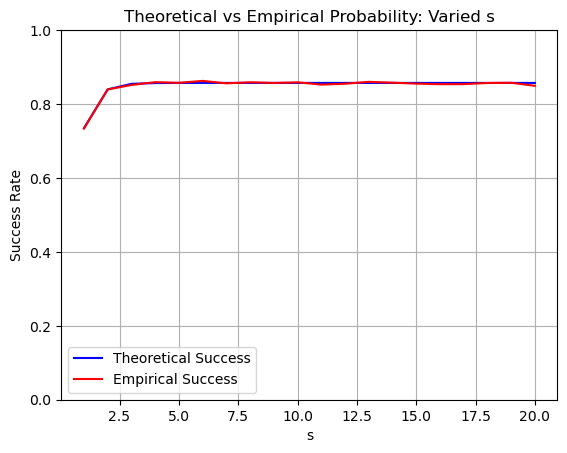

Mean Absolute Error: 0.22%


In [12]:
q = 7
R = PolynomialRing(GF(q), 'x')
x = R.gen()
mult = [i for i in range(1, 21)]
pcon = [x + 4]
invf1 = []
for i in mult:
    invf1.append([[1]]*i)
th, em = exp(pcon, invf1, trials=10000)
plot(th, em, mult, 's', 'Theoretical vs Empirical Probability: Varied s')
print(f'Mean Absolute Error: {MAE(th, em)}')

In [13]:
def irreducible(q, d):
    R = PolynomialRing(GF(q), 'x')
    x = R.gen()
    while True:
        # Generate random polynomial of degree d-1
        coeffs = [GF(q).random_element() for _ in range(d)]
        # Ensure leading coefficient is 1 (monic)
        f = x**d + sum(coeffs[i] * x**i for i in range(d))
        if f.is_irreducible():
            return f

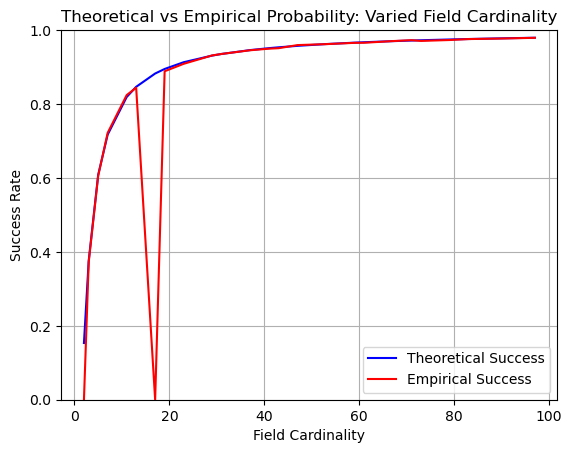

Mean Absolute Error: 4.32%


In [22]:
# Changing field cardinality
primes_list = prime_range(1, 100)
invf = [[1, 1, 1], [0, 1, 1], [0, 0, 1]]
th = []
em = []
for q in primes_list:
    pcon = [irreducible(q, 1), irreducible(q, 2), irreducible(q, 3)]
    th.append(theoretical(pcon, invf))
    em.append(empirical(pcon, invf, trials=10000))
plot(th, em, primes_list, 'Field Cardinality', 'Theoretical vs Empirical Probability: Varied Field Cardinality')
print(f'Mean Absolute Error: {MAE(th, em)}')

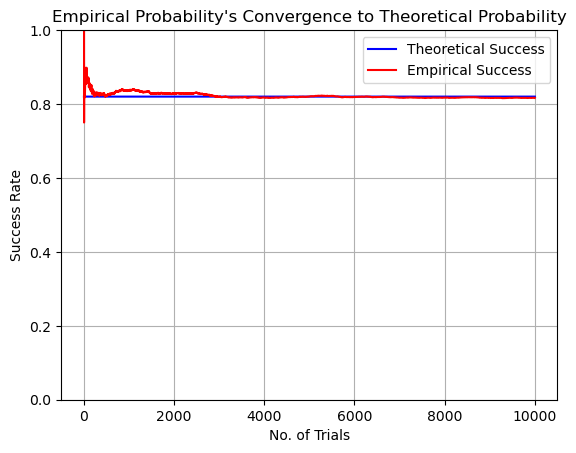

In [15]:
q = 7
trials = 10000
pcon = [x^2 + 3*x + 6, x + 4]
invf = [[1, 1], [0, 1], [0, 1]]
th = []
em = []
error = []

f = GF(q)
A = build_matrix(pcon, invf)
n = A.nrows()
min_poly = A.minpoly()
    
succeeded = 0
for t in range(1, trials + 1):
        u = random_vector(n, f)
        v = random_vector(n, f)
        kappa = [u.dot_product((A^i)*v) for i in range(2*n)]
        mu = berlekamp_massey(kappa)
        mu_monic = mu / mu.leading_coefficient()
        if mu_monic == min_poly:
            succeeded += 1
        em.append(succeeded / t)
        th.append(theoretical(pcon, invf))
        error.append(MAE(th,em))
plot(th, em, [i for i in range(1, trials + 1)], 'No. of Trials', "Empirical Probability's Convergence to Theoretical Probability")

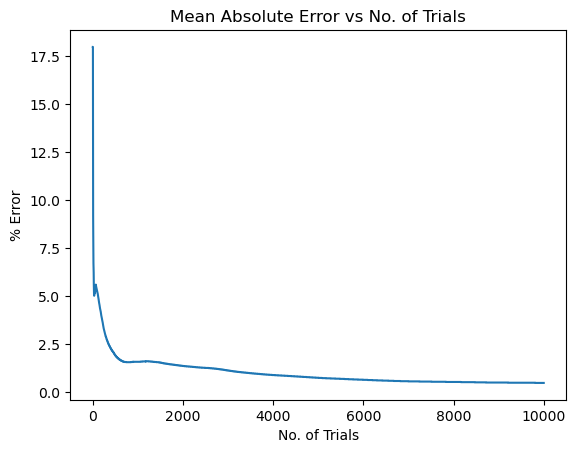

10,000 trials yields 0.49% error.


In [16]:
# print(error)
error_float = [float(e.strip('%')) for e in error]
plt.plot([i for i in range(1, trials + 1)], error_float)
plt.xlabel('No. of Trials')
plt.ylabel('% Error')
plt.title('Mean Absolute Error vs No. of Trials')
plt.show()
print(f'10,000 trials yields {error[-1]} error.')